In [1]:
%%configure -f
{ "conf":{
     "spark.pyspark.python": "python3"
    ,"spark.pyspark.virtualenv.enabled": "true"
    ,"spark.kubernetes.executor.node.selector.node-lifecycle":"spot"
    ,"spark.pyspark.virtualenv.type":"native"
    ,"spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    ,"spark.sql.files.ignoreCorruptFiles":"true"
    ,"spark.dynamicAllocation.executorIdleTimeout":"18000"
    ,"spark.driver.memory":"32g"
    ,"spark.driver.cores":"32"
    ,"spark.driver.maxResultSize":"24g"
    ,"spark.executor.memory":"32g"
    ,"spark.network.timeout":"300"
    ,"spark.executor.cores":"8"
    ,"spark.dynamicAllocation.maxExecutors":"500"
    ,"spark.dynamicAllocation.minExecutors":"1"
    ,"livy.server.session.timeout":"24h"
    ,"spark.sql.shuffle.partitions":"10000"
    }
}  

[I 2024-06-17 16:44:28,656.656 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.kubernetes.executor.node.selector.node-lifecycle": "spot", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.files.ignoreCorruptFiles": "true", "spark.dynamicAllocation.executorIdleTimeout": "18000", "spark.driver.memory": "32g", "spark.driver.cores": "32", "spark.driver.maxResultSize": "24g", "spark.executor.memory": "32g", "spark.network.timeout": "300", "spark.executor.cores": "8", "spark.dynamicAllocation.maxExecutors": "500", "spark.dynamicAllocation.minExecutors": "1", "livy.server.session.timeout": "24h", "spark.sql.shuffle.partitions": "10000"}, "proxyUser": "assumed-role_WSParticipantRole_Participant"}

[I 2024-06-17 16:44:28,656.656 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [109]:
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.window import Window
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings # To suppress some warnings
import os
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

s3_path='s3://demomayst/parquet_mst/'
s3_working_dir='s3://demomayst/cache/'
# col('ReceiptTimestamp') is in nano seconds in UTC timezone so we convert it to unix timestamp in exchange timezone
# keeping first 10 digits and then convert it pySpark timestamp, 
f_hour_from_ns_ts= f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York').cast(t.StringType())[12:2]
select_cols = ['f','Feed','SequenceNumber','Product','ReceiptTimestamp','dt']
nbbo_df= spark.read.parquet(f'{s3_path}mt=nbbo_quote/').where('Feed=="OPRA"').select(select_cols+['BidPrice','BidQuantity','AskPrice','AskQuantity','BestBidParticipant','BestAskParticipant'])\
    .withColumn('dtHour', f_hour_from_ns_ts)\
    .withColumn("ProductUnderlier",f.split(f.col("Product"), ' ', -1).getItem(0))
trade_df= spark.read.parquet(f'{s3_path}mt=trade/').where('Feed=="OPRA"')\
    .select(select_cols+['Price','Quantity','Side','OrderReferenceNumber','LeavesQuantity','MarketParticipant'])\
    .withColumn('dtHour', f_hour_from_ns_ts)\
    .withColumn("ProductUnderlier",f.split(f.col("Product"), ' ', -1).getItem(0))
order_df= spark.read.parquet(f'{s3_path}mt=add_order/').select(select_cols+['Price','Quantity','Side','OrderReferenceNumber']).withColumn('dtHour', f_hour_from_ns_ts)
one_mill_const = 1000000

In [110]:
trade_df.groupBy('Feed').agg(f.min('dt').alias('start_date'),f.max('dt').alias('end_date')).show()
nbbo_df.groupBy('Feed').agg(f.min('dt').alias('start_date'),f.max('dt').alias('end_date')).show()
order_df.groupBy('Feed').agg(f.min('dt').alias('start_date'),f.max('dt').alias('end_date')).show()

+----+----------+----------+
|Feed|start_date|  end_date|
+----+----------+----------+
|OPRA|2023-05-17|2023-05-18|
+----+----------+----------+

+----+----------+----------+
|Feed|start_date|  end_date|
+----+----------+----------+
|OPRA|2023-05-17|2023-05-18|
+----+----------+----------+

+-----+----------+----------+
| Feed|start_date|  end_date|
+-----+----------+----------+
|XDPV2|2023-02-23|2023-02-24|
+-----+----------+----------+



## VOLUME ANALYSIS SECTION ##

In [59]:
#calculate trade $ volume and count per exchange
trade_df.groupBy(['feed','MarketParticipant']).agg((f.sum(f.col('Quantity') * f.col('Price'))/f.lit(one_mill_const)).cast('float').alias("DollarVolume(Million)"),
                           f.count('SequenceNumber').alias("NumOfOrders")).orderBy(['MarketParticipant']).pandas_api()\
.style.format(thousands=',',precision=0).background_gradient()

,feed,MarketParticipant,DollarVolume(Million),NumOfOrders
0,OPRA,BATS,10,"625,726"
1,OPRA,BOX,45,"466,403"
2,OPRA,C2,7,"470,913"
3,OPRA,CBOE,186,"2,429,509"
4,OPRA,EDGX_OPTIONS,8,"697,274"
5,OPRA,ISE,24,"771,279"
6,OPRA,ISE_GEMINI,8,"224,622"
7,OPRA,ISE_MERCURY,3,"175,108"
8,OPRA,MIAX,12,"1,327,870"
9,OPRA,MIAX_EMERALD,6,"414,067"


In [71]:
# below we calculate the following metrics grouped per hour
# trade volume and number of orders per exchangetrade volume and number of orders per hour across all exchanges
trade_df_analysis = trade_df\
.groupBy(['dtHour']).agg(
     f.countDistinct('OrderReferenceNumber').alias("NumOfOrders"),
    f.round(f.sum(f.col('Quantity') * f.col('Price'))/f.lit(one_mill_const),0).cast('float').alias("DollarVolume(Million)")
                        ).orderBy(['dtHour']).cache()

trade_df_analysis.pandas_api().style.format(thousands=',',precision=0).background_gradient()
# what you need to do:
# calculate the overall trading volume for work hours vs after-hours 
# calculating distinct values over high-cardinality column may be expensive, you can try calcualting approximate distinct count and see what performance improvements it brings.   

,dtHour,NumOfOrders,DollarVolume(Million)
0,00,0,0
1,01,0,0
2,02,0,0
3,03,0,0
4,04,0,0
5,05,0,0
6,06,0,0
7,07,0,0
8,08,0,1
9,09,0,29


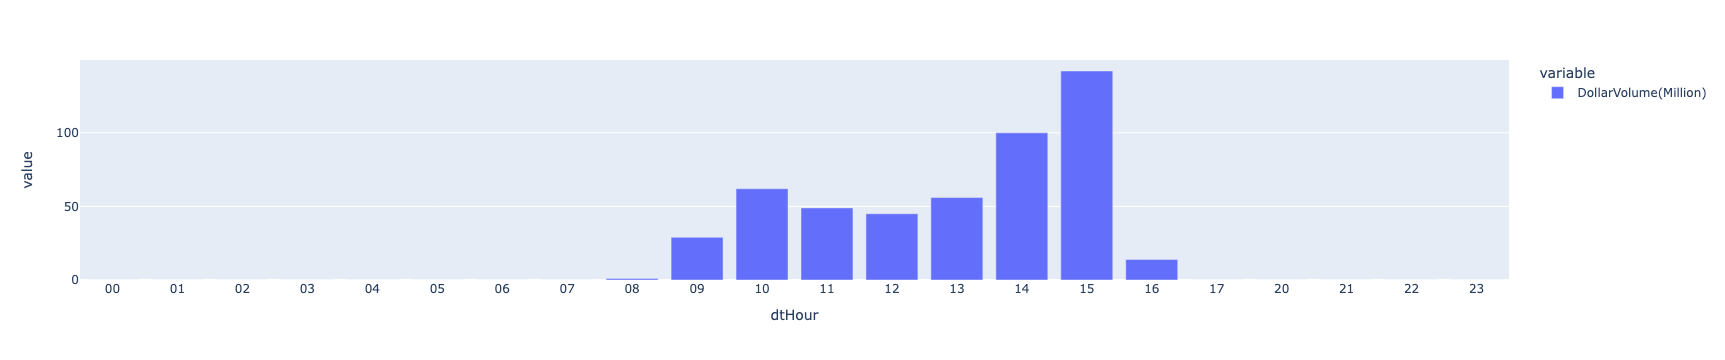

In [72]:
#plot line graph based on spark query results using seaborn
#import seaborn as sns
#sns.set_theme()
#ax = sns.relplot(
#    data=order_df_analysis.select('dtHour','DollarVolume').withColumn('DollarVolume(millions)',f.col('DollarVolume')/1000000).orderBy('dtHour').toPandas(), 
#    height=3, aspect=3.5, kind='line',
#    x="dtHour", y="DollarVolume(millions)"
#) 
trade_df_analysis.pandas_api().set_index('dtHour')[['DollarVolume(Million)']].plot.bar()

In [105]:
# get some individual tickers to analyse
sample_tickers=['AMZN','MSFT','GS','GE']
# calculate daily volumes for those tickers
plot_df = trade_df.filter(trade_df.ProductUnderlier.isin(sample_tickers)).select(
    f.col('dtHour'),'dt', 'ProductUnderlier', 'Quantity', 'Price','MarketParticipant','Feed')\
    .groupBy('dt','dtHour','ProductUnderlier','MarketParticipant','Feed')\
    .agg(f.sum(f.col('Quantity')*f.col('Price')/f.lit(one_mill_const)).alias('DollarVolume(Millions)')
).cache()

#calculate percentage of stock's volume on given exchange vs total volume on all exchanges(Feed) per hour of the day
plot_df=plot_df.withColumn('Percent',  
    (100*f.col('DollarVolume(Millions)'))/f.sum('DollarVolume(Millions)').over(Window.partitionBy(['dt','dtHour','ProductUnderlier']))
)

#calculate percentage of stock's volume on given exchange per hour across all days vs total stock volume on all exchanges(Feed) per hour across all days
plot_df=plot_df.withColumn('PercentHour',  
    (100*f.sum('DollarVolume(Millions)').over(Window.partitionBy(['dtHour','ProductUnderlier','MarketParticipant'])))/f.sum('DollarVolume(Millions)').over(Window.partitionBy(['dtHour','ProductUnderlier']))
)

plot_df.show()

+----------+------+----------------+-----------------+----+----------------------+---------+-----------+
|        dt|dtHour|ProductUnderlier|MarketParticipant|Feed|DollarVolume(Millions)|  Percent|PercentHour|
+----------+------+----------------+-----------------+----+----------------------+---------+-----------+
|2023-05-17|    09|            AMZN|             BATS|OPRA|              0.036759| 9.157584|   8.589895|
|2023-05-18|    09|            AMZN|             BATS|OPRA|              0.035967| 8.078097|   8.589895|
|2023-05-17|    09|            AMZN|              BOX|OPRA|              0.036830| 9.175272|   7.252027|
|2023-05-18|    09|            AMZN|              BOX|OPRA|              0.024569| 5.518135|   7.252027|
|2023-05-17|    09|            AMZN|               C2|OPRA|              0.014750| 3.674593|   3.570441|
|2023-05-18|    09|            AMZN|               C2|OPRA|              0.015479| 3.476544|   3.570441|
|2023-05-17|    09|            AMZN|             CBOE|O

In [107]:
plot_pd = plot_df.toPandas()
#convertion to pandas looses schema, so need to reset the types
plot_pd['DollarVolume(Millions)']=plot_pd['DollarVolume(Millions)'].astype('float');
plot_pd['PercentHour']=plot_pd['PercentHour'].astype('float');
plot_pd['ProductUnderlier']=plot_pd['ProductUnderlier'].astype('string');
plot_pd['dt']=plot_pd['dt'].astype('string');
plot_pd['dtHour']=plot_pd['dtHour'].astype('string');

plot_pd_wide =pd.pivot_table(plot_pd, values='PercentHour', index=['ProductUnderlier','MarketParticipant'],
                       columns=['dtHour']).fillna(0)
plot_pd_wide.style.format(thousands=',',precision=0).background_gradient(axis=0)
#BL: graph it as stacked bars to easily visualize exchange market share would be good visual

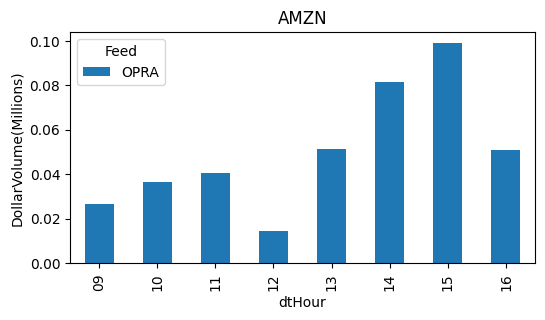

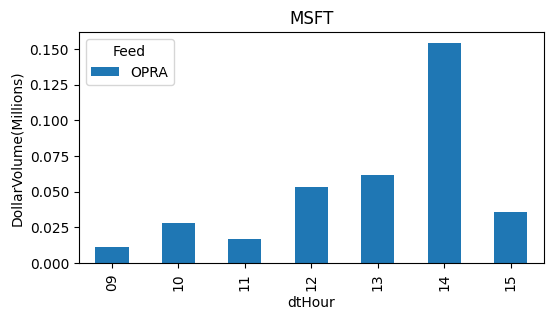

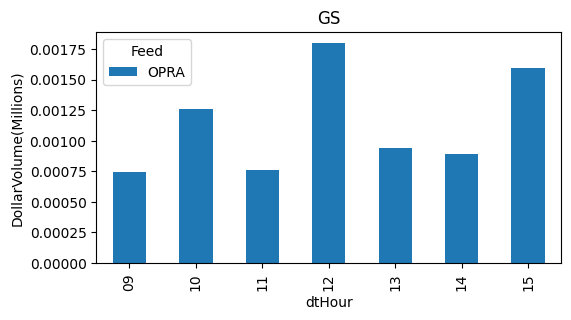

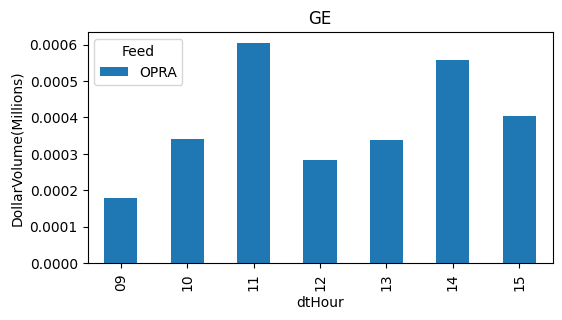

In [108]:
#generate visual using built-in pandas integration with matplotlib
# we use toPandas() here 
for one_t in sample_tickers:
    plot_pd.query(f"ProductUnderlier=='{one_t}'").pivot_table(index=["dtHour"], columns=["Feed"],values="DollarVolume(Millions)")\
    .plot(title=f"{one_t}",kind="bar", stacked='True', ylabel="DollarVolume(Millions)", figsize=(6, 3))

#BL: broke this by adding one more field - tried to fix it but gave up since i rarely use seaborn

## TRADES SECTION ##

In [158]:
#cover for order partial refills, replacing price with vwap price and timestamp with the latest filled part of the order
#we also make sure we only look for the fully filled orders, last LeavesQuantity=0 
vWAP_group_by_cols = ['OrderReferenceNumber','Product','ProductUnderlier','Side','Feed','f',"dtHour",'dt']
trade_df_grouped = trade_df.groupBy(vWAP_group_by_cols).agg(
    f.sum(f.col('Quantity')).alias('weight_sum'),
    f.sum(f.col('Quantity')).alias('Quantity'),
    f.sum(f.col('Quantity') * f.col('Price')).alias('weight_price_sum'),
    f.min('ReceiptTimestamp').alias('ReceiptTimestamp'),
    f.last(f.col('LeavesQuantity'),True).alias('Unfilled'),
    f.count(f.col('SequenceNumber')).alias('fill_count')
).withColumn('vWAP',f.col('weight_price_sum')/f.col('weight_sum')).cache()#.filter(f.col('Unfilled')<1).cache()
trade_df_grouped.where('ProductUnderlier=="AMZN" and fill_count between 3 and 5').orderBy(['fill_count','Product'],ascending=False).show(truncate=False)
sample_set={}
sample_set['Product']='AMZN  251219P00080000'
sample_set['dt']='2023-05-17'
sample_set['dtHour']='09'
trade_df.where(f"Product=='{sample_set['Product']}' and dt=='{sample_set['dt']}' and dtHour=='{sample_set['dtHour']}'").show(truncate=False)
trade_df_grouped.where(f"Product=='{sample_set['Product']}' and dt=='{sample_set['dt']}' and dtHour=='{sample_set['dtHour']}'").show(truncate=False)

+--------------------+---------------------+----------------+----+----+----+------+----------+-----------------------+-----------------------+----------------+-------------------+--------+----------+---------+
|OrderReferenceNumber|Product              |ProductUnderlier|Side|Feed|f   |dtHour|dt        |weight_sum             |Quantity               |weight_price_sum|ReceiptTimestamp   |Unfilled|fill_count|vWAP     |
+--------------------+---------------------+----------------+----+----+----+------+----------+-----------------------+-----------------------+----------------+-------------------+--------+----------+---------+
|null                |AMZN  251219P00080000|AMZN            |null|OPRA|opra|09    |2023-05-17|11.0000000000000000000 |11.0000000000000000000 |80.250000       |1684330408562334947|null    |5         |7.295455 |
|null                |AMZN  251219P00070000|AMZN            |null|OPRA|opra|10    |2023-05-18|5.0000000000000000000  |5.0000000000000000000  |23.350000       |1

In [159]:
expected_val = (7.3*1+7.3*2+7.3*2+7.29*5+7.3*1)/(1+2+2+5+1)
actual_val=float(trade_df_grouped.where(f"Product=='{sample_set['Product']}' and dt=='{sample_set['dt']}' and dtHour=='{sample_set['dtHour']}'").select('vWAP').toPandas().values[0][0])
print(round(expected_val,5),round(actual_val,5))
assert round(expected_val,5)==round(actual_val,5)

7.29545 7.29545


In [160]:
#create the union of trades and nbbo data to simulate as-of join 
# normalize list of columns for trades_df and nbbo_df, initialize missing columns as nulls
#we also add DataType column initialised as 1 for trades and 0 for nbbo to separate datasets
trade_df_grouped=trade_df_grouped\
    .withColumn('BidPrice',f.lit(None).cast(t.NullType()))\
    .withColumn('BidQuantity',f.lit(None).cast(t.NullType()))\
    .withColumn('AskPrice',f.lit(None).cast(t.NullType()))\
    .withColumn('AskQuantity',f.lit(None).cast(t.NullType()))\
    .withColumn('DataType',f.lit(1).cast(t.IntegerType()))#.where("Feed=='OPRA'")
nbbo_df = nbbo_df.withColumn('vWAP',f.lit(None).cast(t.NullType()))\
    .withColumn('Quantity',f.lit(None).cast(t.NullType()))\
    .withColumn('Side',f.lit(None).cast(t.NullType()))\
    .withColumn('DataType',f.lit(0).cast(t.IntegerType()))

#union both dataframes, and make sure the names are order of columns are identical
#BL: i added Feed and f as helps to create a story later
select_cols = ["Feed","f",'Product','dtHour','vWAP','Quantity','Side','BidPrice','BidQuantity','AskPrice','AskQuantity','ReceiptTimestamp','DataType','dtHour','dt']
trade_nbbo_df = trade_df_grouped.select(select_cols)\
.union(nbbo_df.select(select_cols))\
.withColumn('ReceiptTimestampEST',f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York'))
trade_nbbo_df.show()

+----+----+--------------------+------+----------+--------------------+----+--------+-----------+--------+-----------+-------------------+--------+------+----------+-------------------+
|Feed|   f|             Product|dtHour|      vWAP|            Quantity|Side|BidPrice|BidQuantity|AskPrice|AskQuantity|   ReceiptTimestamp|DataType|dtHour|        dt|ReceiptTimestampEST|
+----+----+--------------------+------+----------+--------------------+----+--------+-----------+--------+-----------+-------------------+--------+------+----------+-------------------+
|OPRA|opra|SPY   230519C0041...|    14|  1.039073|6980.000000000000...|null|    null|       null|    null|       null|1684346402439564086|       1|    14|2023-05-17|2023-05-17 14:00:02|
|OPRA|opra|SPY   230522C0041...|    09|  1.000154|1103.000000000000...|null|    null|       null|    null|       null|1684330230930803827|       1|    09|2023-05-17|2023-05-17 09:30:30|
|OPRA|opra|SPY   230519C0041...|    16|  4.755000|14.00000000000000...

In [161]:
#select active Products to sample
ptile_win = Window.partitionBy('Feed').orderBy("d_count")
sample_trade_df=trade_df_grouped\
.groupBy('Product','Feed').agg(f.count('f').alias('d_count'))\
.withColumn('d_count_ptile',f.percent_rank().over(ptile_win))\
.orderBy(['d_count_ptile'],ascending=False).where("(Product like 'AM%') and d_count_ptile between 0.95 and 0.992")
print(sample_trade_df.count())
sample_products=[i.__getitem__('Product') for i in sample_trade_df.orderBy(['d_count_ptile'],ascending=False).take(50)]

576


In [162]:
from pyspark.sql.window import Window
#we are looking for the closest timestamp to the current row. 
lookup_window=Window.partitionBy('Product').orderBy("Feed","f",'ReceiptTimestamp','DataType').rowsBetween(Window.unboundedPreceding, Window.currentRow)
sample_product_list="'"+"','".join(sample_products)+"'"
sample_product_list

"'AMZN  230526C00118000','AMC   230616C00010000','AMD   230602C00105000','AMD   230609P00095000','AMZN  230623C00112000','AMD   230818P00090000','AMC   230526C00004500','AMZN  230602C00120000','AMD   230616P00110000','AMD   230915C00095000','AMAT  230721C00130000','AMD   230818P00085000','AMZN  230616P00100000','AMC   230519P00006000','AMAT  230519P00123000','AMD   230602C00115000','AMZN  230602C00113000','AMAT  230616C00135000','AMZN  230602C00111000','AMZN  230519P00102000','AMZN  230602P00100000','AMD   230519C00105000','AMAT  230519P00120000','AMZN  240119P00115000','AMAT  230526C00128000','AMZN  230915C00125000','AMD   230721C00100000','AMAT  230519C00127000','AMZN  230623C00120000','AMD   230526P00098000','AMAT  230519P00114000','AMZN  230915C00120000','AMZN  230609P00115000','AMC   230616C00008000','AMD   230526P00088000','AMD   240119C00130000','AMD   230616C00105000','AMZN  230721P00110000','AMD   230721P00110000','AMD   230630C00125000','AMZN  230519C00107000','AMD   230609P0

In [163]:
cache_file_name = f"{s3_working_dir}/trade_nbbo_price.parquet"
if False:
    # caclulate the price difference based on Nbbo midpoint
    trade_nbbo_price = trade_nbbo_df\
        .where(f'Product in ({sample_product_list})').select('Feed','f','Product','vWAP','Quantity','Side','ReceiptTimestamp','ReceiptTimestampEST','dtHour','dt',
        f.last('AskPrice', True).over(lookup_window).alias('AskPriceNbbo'),
        f.last('BidPrice', True).over(lookup_window).alias('BidPriceNbbo'),
        f.last(f.when(f.col('DataType') < 1, f.col('ReceiptTimestamp') ).otherwise(None), True).over(lookup_window).alias('TimestampNbbo')        
        )\
        .withColumn('MidPrice', (f.col('AskPriceNbbo') + f.col('BidPriceNbbo'))/2)\
        .withColumn('ArrivalPriceImprovementBP', ((f.col('vWAP') -f.col('MidPrice'))/f.col('MidPrice') )*1000).filter(f.col('AskPrice').isNull())#.cache()
    union_partition_columns=['dt','Product']
    trade_nbbo_price.repartition(*union_partition_columns).write.partitionBy(*union_partition_columns)\
       .mode('overwrite').parquet(cache_file_name)
trade_nbbo_price=spark.read.parquet(cache_file_name)

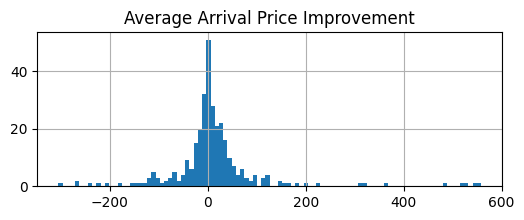

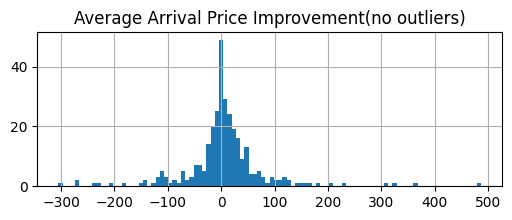

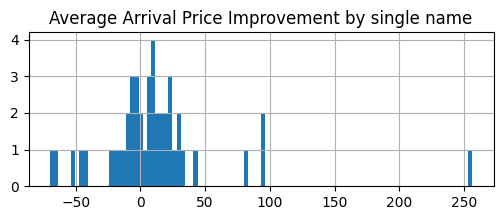

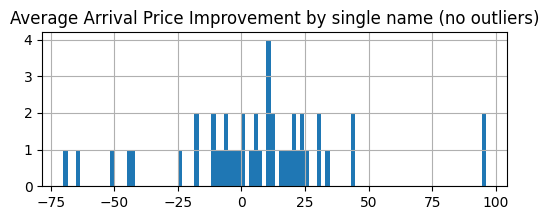

In [164]:
# please check if gap fill forward works properly and then we just remove filter on top to do this visual accross the board
# we use a few selected products only for visualisation purposes

right_tale_limit = 500
arrival_price_stats_pd=trade_nbbo_price.groupby('dtHour','Feed','f','Product').agg(f.mean('ArrivalPriceImprovementBP')\
.alias('AvgArrivalPriceImprovementBP')).where("AvgArrivalPriceImprovementBP is not null").toPandas()

arrival_price_stats_less_oiutliers_pd=arrival_price_stats_pd.query(f"AvgArrivalPriceImprovementBP<{right_tale_limit}")
#arrival_price_stats_pd.groupby('Product').agg(f.mean('AvgArrivalPriceImprovementBP').alias('AvgArrivalPriceImprovementBP')).pandas_api()[["AvgArrivalPriceImprovementBP"]].astype(float).hist()
def graph_hist(l_df,l_title,bins=100,figsize=(6,2)):
    l_df.hist(bins=bins,figsize=figsize);plt.title(l_title);
    plt.suptitle('').set_visible(False)
graph_hist((arrival_price_stats_pd[['AvgArrivalPriceImprovementBP']].astype(float)),"Average Arrival Price Improvement")
graph_hist(arrival_price_stats_less_oiutliers_pd[['AvgArrivalPriceImprovementBP']].astype(float),"Average Arrival Price Improvement(no outliers)")
graph_hist(arrival_price_stats_pd.groupby('Product').agg(AvgArrivalPriceImprovementBP=("AvgArrivalPriceImprovementBP","mean")).astype(float),"Average Arrival Price Improvement by single name")
graph_hist(arrival_price_stats_less_oiutliers_pd.groupby('Product').agg(AvgArrivalPriceImprovementBP=("AvgArrivalPriceImprovementBP","mean")).astype(float),"Average Arrival Price Improvement by single name (no outliers)")

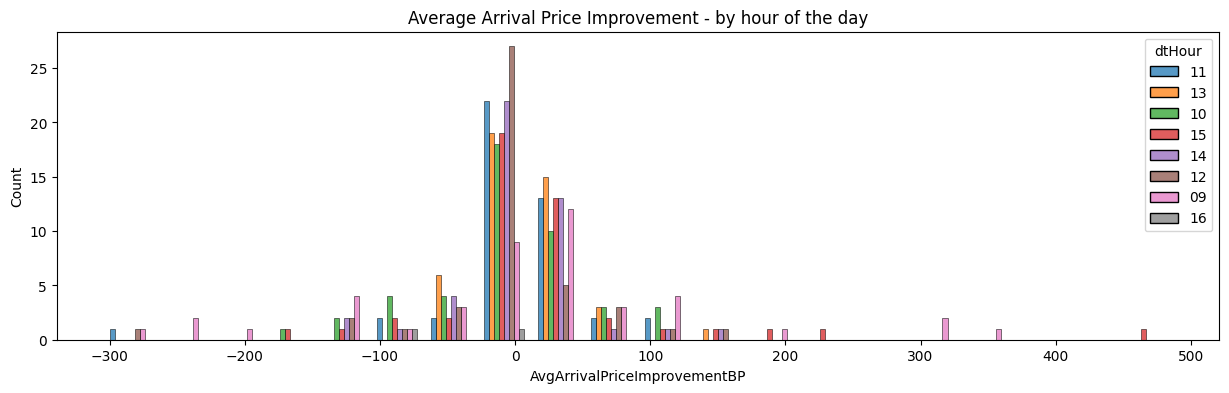

In [165]:
plt.figure(figsize=(15,4));
sns.histplot(arrival_price_stats_less_oiutliers_pd, x='AvgArrivalPriceImprovementBP', hue='dtHour',multiple='dodge', shrink=.75, bins=20)\
.set_title('Average Arrival Price Improvement - by hour of the day');

In [169]:
#pick few orders to sample to simulate "your own" trades
#trade_df.filter(f.col('OrderReferenceNumber')=='1000045252').show(10)
lookback_offset=10*1000*1000*1000*60
trade_stats_df=trade_nbbo_price.where(f"{sample_where_clause}")\
.groupBy("ReceiptTimestamp","Product","Feed",'f','dt','dtHour','Side').agg(f.count('ReceiptTimestamp').alias('partial_count'),
                                                                  f.min('ReceiptTimestamp').alias('fill_start'),
                                                                  f.max('ReceiptTimestamp').alias('fill_end')
                                                                 )\
.select("*",
        (f.col('fill_start')-lookback_offset).alias('ts_start'),
        (f.col('fill_end')+lookback_offset).alias('ts_end'),
        f.round((f.col("ts_end")-f.col("ts_start"))/1000/1000/1000/60,1).alias('fill_duration_min')
       )
print(trade_stats_df.count())
trade_stats_df.orderBy('partial_count','fill_duration_min',ascending=False).orderBy('Product').show()
sample_trades=trade_stats_df.drop('fill_start','fill_end').join(trade_nbbo_price.where(sample_where_clause).where('dtHour between "09" and "16" '),on=['ReceiptTimestamp',"Product",'dt','dtHour','Feed','f'])\
    .select('Product','dt','dtHour','Feed','f','ReceiptTimestamp','partial_count','ts_start','ts_end','fill_duration_min','vWAP' )
sample_trades.show(10)
print(sample_trades.count())
sample_trades_dict=sample_trades.orderBy("ReceiptTimestamp",ascending=False).take(30)


365
+-------------------+--------------------+----+----+----------+------+----+-------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|   ReceiptTimestamp|             Product|Feed|   f|        dt|dtHour|Side|partial_count|         fill_start|           fill_end|           ts_start|             ts_end|fill_duration_min|
+-------------------+--------------------+----+----+----------+------+----+-------------+-------------------+-------------------+-------------------+-------------------+-----------------+
|1684330200233133837|AMZN  230519C0010...|OPRA|opra|2023-05-17|    09|null|            1|1684330200233133837|1684330200233133837|1684329600233133837|1684330800233133837|             20.0|
|1684332189338433504|AMZN  230519C0010...|OPRA|opra|2023-05-17|    10|null|            1|1684332189338433504|1684332189338433504|1684331589338433504|1684332789338433504|             20.0|
|1684350756172136940|AMZN  230519C0010...|OPRA|opra|2023

In [170]:
where_list=[]
where_list_trades=[]
for one_trade_det in sample_trades_dict:
    product,ts_s,ts_e,ReceiptTimestamp=one_trade_det['Product'],one_trade_det['ts_start'],one_trade_det['ts_end'],one_trade_det['ReceiptTimestamp']
    where_list.append(f"Product=='{product}' and (ReceiptTimestamp between {ts_s} and  {ts_e}) ")
    where_list_trades.append(f"Product=='{product}' and ReceiptTimestamp=='{ReceiptTimestamp}'")
where_text = "("+') OR ('.join(where_list)+")"
where_text_trades = "("+') OR ('.join(list(set(where_list_trades)))+")"
print(where_text,where_text_trades)

(Product=='AMZN  230526C00118000' and (ReceiptTimestamp between 1684439452661814272 and  1684440652661814272) ) OR (Product=='AMZN  230526P00095000' and (ReceiptTimestamp between 1684438692106451101 and  1684439892106451101) ) OR (Product=='AMZN  230519P00103000' and (ReceiptTimestamp between 1684438651534415513 and  1684439851534415513) ) OR (Product=='AMZN  231020P00115000' and (ReceiptTimestamp between 1684438313125363536 and  1684439513125363536) ) OR (Product=='AMZN  230519P00107000' and (ReceiptTimestamp between 1684438300601381450 and  1684439500601381450) ) OR (Product=='AMZN  240119C00105000' and (ReceiptTimestamp between 1684438226174897842 and  1684439426174897842) ) OR (Product=='AMZN  230609P00110000' and (ReceiptTimestamp between 1684437992550783917 and  1684439192550783917) ) OR (Product=='AMZN  230609C00115000' and (ReceiptTimestamp between 1684437561524215966 and  1684438761524215966) ) OR (Product=='AMZN  250117C00115000' and (ReceiptTimestamp between 1684437171653217

In [171]:
print(nbbo_df.where(where_text).count())
print(sample_trades.where(where_text_trades).count())

1182411
30


In [172]:
nbbo_sample_pd  = nbbo_df.where(where_text).toPandas()
sample_trades_pd=sample_trades.where(where_text_trades).toPandas()

In [173]:
nbbo_sample_pd.set_index(['Product','ReceiptTimestamp']).sort_index().head(20)

f  Feed SequenceNumber  \
Product               ReceiptTimestamp                                 
AMZN  230519C00108000 1684436132929634109  opra  OPRA      580460189   
                      1684436132964752957  opra  OPRA      580460578   
                      1684436132964782878  opra  OPRA      580460581   
                      1684436132965123802  opra  OPRA      580460590   
                      1684436132971077747  opra  OPRA      580460733   
                      1684436132976606115  opra  OPRA      580460877   
                      1684436132978305049  opra  OPRA      580460905   
                      1684436133167386643  opra  OPRA      580462636   
                      1684436133274555407  opra  OPRA      580464076   
                      1684436133284223355  opra  OPRA      580464747   
                      1684436133288533635  opra  OPRA      580464832   
                      1684436133299163922  opra  OPRA      580464956   
                      1684436135896510422  opra  OPRA      580500019   
                      1684436135906179659  opra  OPRA      580502109   
                      1684436135906843081  opra  OPRA      580503675   
                      1684436135907447159  opra  OPRA      580505284   
                      1684436135911084689  opra  OPRA      580507920   
                      1684436135911540150  opra  OPRA      580508173   
                      1684436135913489371  opra  OPRA      580509201   
                      1684436135915170446  opra  OPRA      580509729   

                                                   dt               BidPrice  \
Product               ReceiptTimestamp                                         
AMZN  230519C00108000 1684436132929634109  2023-05-18  8.8500000000000000000   
                      1684436132964752957  2023-05-18  8.8500000000000000000   
                      1684436132964782878  2023-05-18  8.8500000000000000000   
                      1684436132965123802  2023-05-18  8.8500000000000000000   
                      1684436132971077747  2023-05-18  8.8500000000000000000   
                      1684436132976606115  2023-05-18  8.8500000000000000000   
                      1684436132978305049  2023-05-18  8.8500000000000000000   
                      1684436133167386643  2023-05-18  8.8500000000000000000   
                      1684436133274555407  2023-05-18  8.8500000000000000000   
                      1684436133284223355  2023-05-18  8.8500000000000000000   
                      1684436133288533635  2023-05-18  8.8500000000000000000   
                      1684436133299163922  2023-05-18  8.8500000000000000000   
                      1684436135896510422  2023-05-18  8.8500000000000000000   
                      1684436135906179659  2023-05-18  8.8500000000000000000   
                      1684436135906843081  2023-05-18  8.8500000000000000000   
                      1684436135907447159  2023-05-18  8.8500000000000000000   
                      1684436135911084689  2023-05-18  8.8500000000000000000   
                      1684436135911540150  2023-05-18  8.8500000000000000000   
                      1684436135913489371  2023-05-18  8.8500000000000000000   
                      1684436135915170446  2023-05-18  8.8500000000000000000   

                                           BidQuantity               AskPrice  \
Product               ReceiptTimestamp                                          
AMZN  230519C00108000 1684436132929634109       1789.0  9.0500000000000000000   
                      1684436132964752957       1834.0  9.0500000000000000000   
                      1684436132964782878       1831.0  9.0500000000000000000   
                      1684436132965123802       1830.0  9.0500000000000000000   
                      1684436132971077747       1829.0  9.0500000000000000000   
                      1684436132976606115       1826.0  9.0500000000000000000   
                      1684436132978305049       1871

In [174]:
sample_trades_pd.set_index(['Product','ReceiptTimestamp']).sort_index()

dt dtHour  Feed     f  \
Product               ReceiptTimestamp                                     
AMZN  230519C00108000 1684436732895537972  2023-05-18     15  OPRA  opra   
AMZN  230519C00116000 1684436400046686924  2023-05-18     15  OPRA  opra   
AMZN  230519P00103000 1684439251534415513  2023-05-18     15  OPRA  opra   
AMZN  230519P00107000 1684438900601381450  2023-05-18     15  OPRA  opra   
AMZN  230519P00117000 1684436449728152789  2023-05-18     15  OPRA  opra   
AMZN  230526C00118000 1684436417046716764  2023-05-18     15  OPRA  opra   
                      1684440052661814272  2023-05-18     16  OPRA  opra   
AMZN  230526C00121000 1684436600673964567  2023-05-18     15  OPRA  opra   
AMZN  230526P00095000 1684434333323425240  2023-05-18     14  OPRA  opra   
                      1684439292106451101  2023-05-18     15  OPRA  opra   
AMZN  230526P00102000 1684437091165177211  2023-05-18     15  OPRA  opra   
AMZN  230526P00109000 1684437108161527685  2023-05-18     15  OPRA  opra   
AMZN  230602C00110000 1684436966619522050  2023-05-18     15  OPRA  opra   
AMZN  230609C00112000 1684437034096676759  2023-05-18     15  OPRA  opra   
AMZN  230609C00115000 1684435781617842733  2023-05-18     14  OPRA  opra   
                      1684438161524215966  2023-05-18     15  OPRA  opra   
AMZN  230609C00118000 1684436459212921880  2023-05-18     15  OPRA  opra   
AMZN  230609P00110000 1684438592550783917  2023-05-18     15  OPRA  opra   
AMZN  230616C00115000 1684436484024086505  2023-05-18     15  OPRA  opra   
AMZN  230616P00096000 1684437568416383087  2023-05-18     15  OPRA  opra   
AMZN  230630C00116000 1684436722245792493  2023-05-18     15  OPRA  opra   
AMZN  230630P00105000 1684437580337430275  2023-05-18     15  OPRA  opra   
AMZN  230721C00100000 1684437459112048484  2023-05-18     15  OPRA  opra   
AMZN  230721C00120000 1684436440057168729  2023-05-18     15  OPRA  opra   
AMZN  230721C00125000 1684436558382411122  2023-05-18     15  OPRA  opra   
AMZN  230818C00110000 1684437631881047315  2023-05-18     15  OPRA  opra   
AMZN  231020P00115000 1684438913125363536  2023-05-18     15  OPRA  opra   
AMZN  240119C00105000 1684438826174897842  2023-05-18     15  OPRA  opra   
AMZN  250117C00115000 1684435796153077065  2023-05-18     14  OPRA  opra   
                      1684437771653217658  2023-05-18     15  OPRA  opra   

                                           partial_count             ts_start  \
Product               ReceiptTimestamp                                          
AMZN  230519C00108000 1684436732895537972              1  1684436132895537972   
AMZN  230519C00116000 1684436400046686924              1  1684435800046686924   
AMZN  230519P00103000 1684439251534415513              1  1684438651534415513   
AMZN  230519P00107000 1684438900601381450              1  1684438300601381450   
AMZN  230519P00117000 1684436449728152789              1  1684435849728152789   
AMZN  230526C00118000 1684436417046716764              1  1684435817046716764   
                      1684440052661814272              1  1684439452661814272   
AMZN  230526C00121000 1684436600673964567              1  1684436000673964567   
AMZN  230526P00095000 1684434333323425240              1  1684433733323425240   
                      1684439292106451101              1  1684438692106451101   
AMZN  230526P00102000 1684437091165177211              1  1684436491165177211   
AMZN  230526P00109000 1684437108161527685              1  1684436508161527685   
AMZN  230602C00110000 1684436966619522050              1  1684436366619522050   
AMZN  230609C00112000 1684437034096676759              1  1684436434096676759   
AMZN  230609C00115000 1684435781617842733              1  1684435181617842733   
                      1684438161524215966              1  1684437561524215966   
AMZN  230609C00118000 1684436459212921880              1  1684435859212921880   
AMZN  230609P00110000 1684438592550783917              1  1684437992550783917  

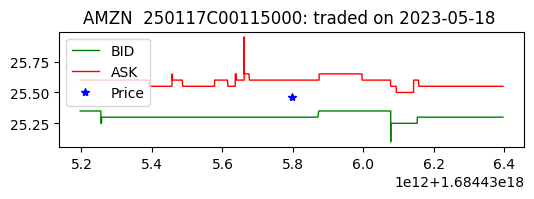

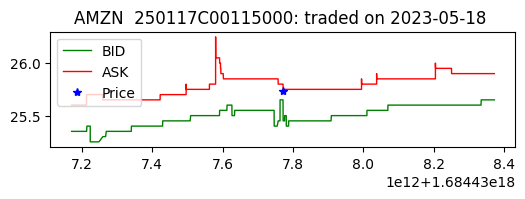

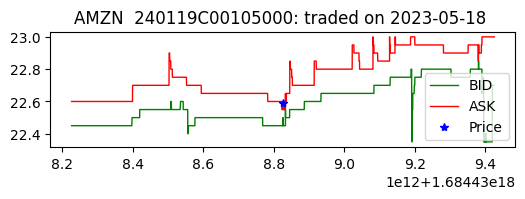

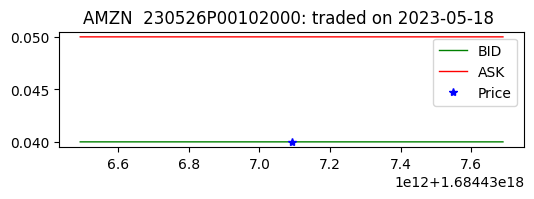

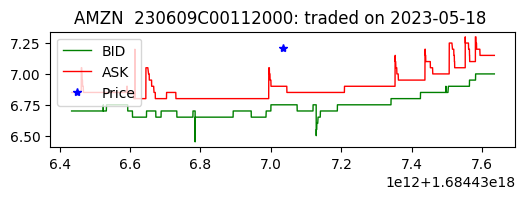

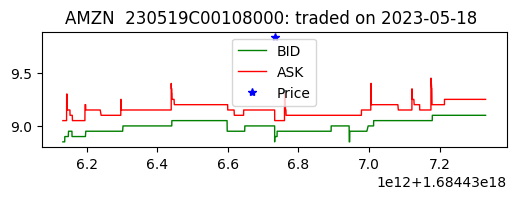

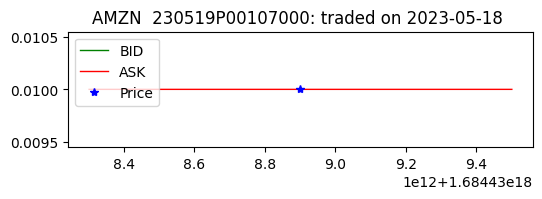

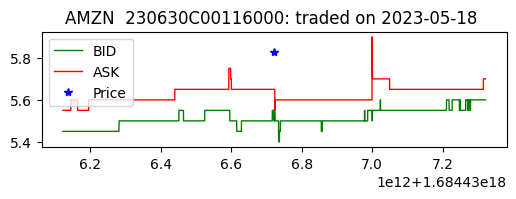

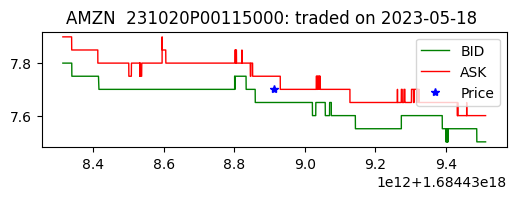

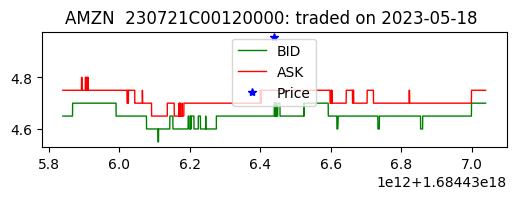

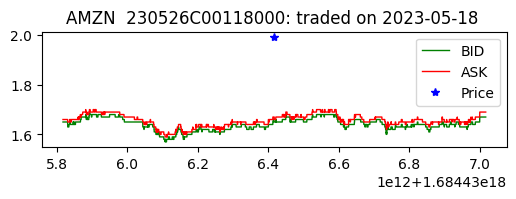

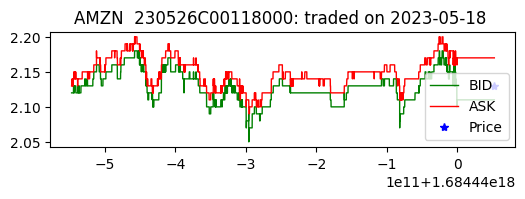

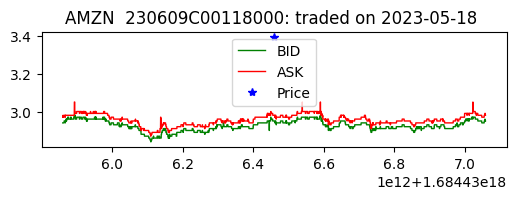

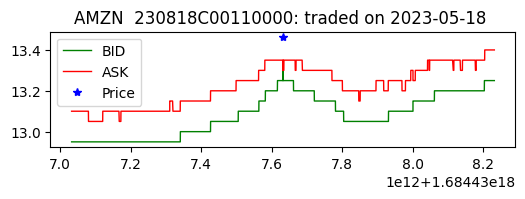

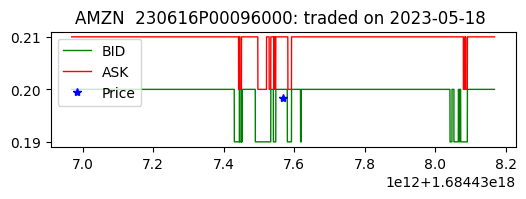

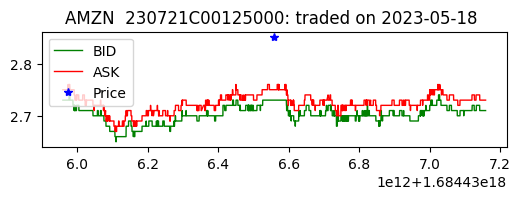

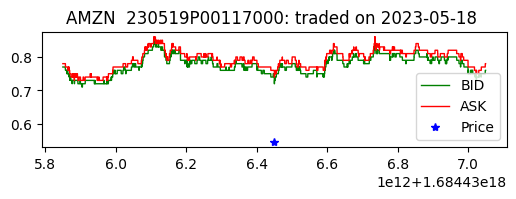

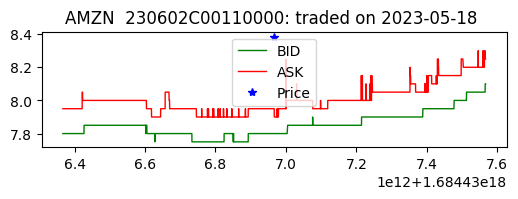

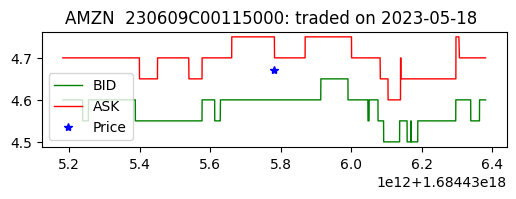

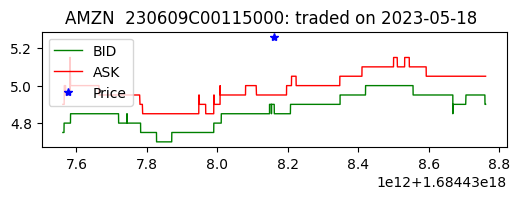

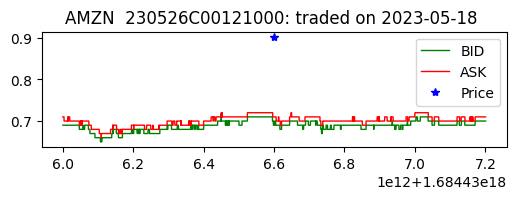

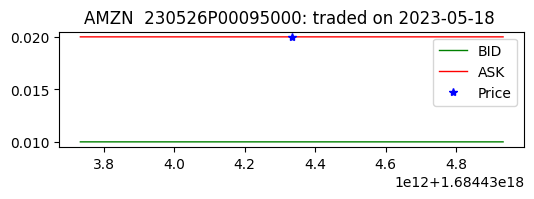

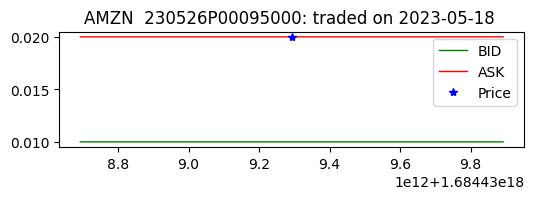

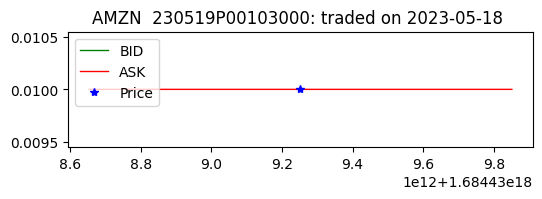

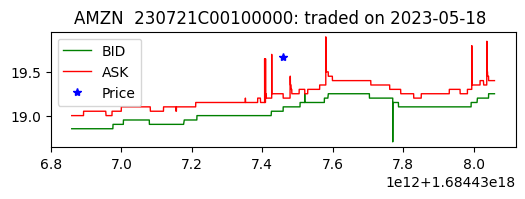

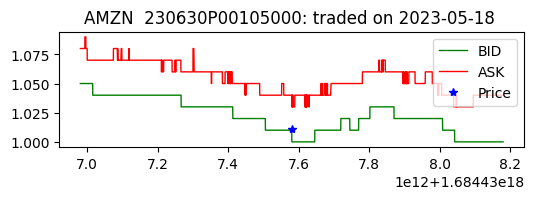

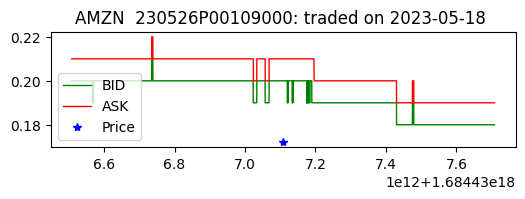

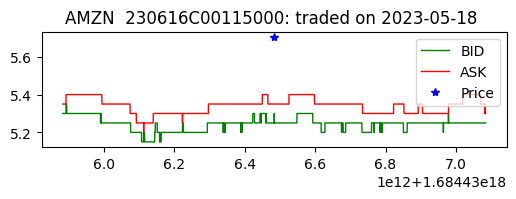

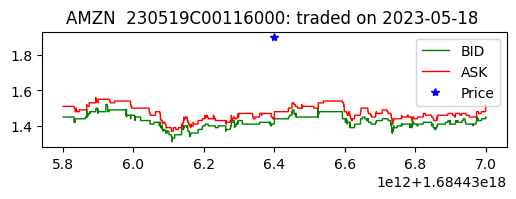

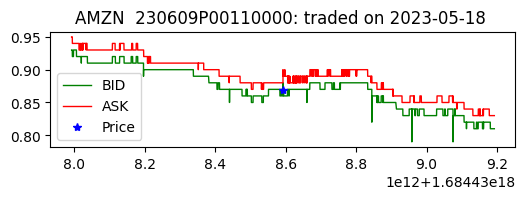

In [175]:
plt.rcParams["figure.figsize"] = (6,1.5)
for one_ord in sample_trades_pd[['Product','ts_start','ts_end','dt','vWAP','ReceiptTimestamp']].drop_duplicates().dropna().iterrows():
    prod=one_ord[1].Product
    ts_start = (one_ord[1].ts_start)
    ts_end = (one_ord[1].ts_end)
    dt_tr = str(one_ord[1]['dt'])
    one_pd = nbbo_sample_pd[['BidPrice','AskPrice','Product','ReceiptTimestamp']].query(f"Product=='{prod}'").query(f"ReceiptTimestamp>={ts_start}").query(f"ReceiptTimestamp<={ts_end}").sort_index()
    plot_pd =pd.DataFrame([one_ord[1]]).set_index(['Product','ReceiptTimestamp']).join(one_pd.set_index(['Product','ReceiptTimestamp']),how='outer').drop(columns=['dt','ts_start','ts_end']).astype(float)
    
    plot_title = f"{prod}: traded on {dt_tr} "
    #one_pd[['BidPrice','Price','AskPrice']].plot(figsize=(10,3),title=plot_title)
    plt.plot(plot_pd.reset_index()['ReceiptTimestamp'],plot_pd['BidPrice'].ffill(), marker='', color='green', linewidth=1, label="BID")
    plt.plot(plot_pd.reset_index()['ReceiptTimestamp'],plot_pd['AskPrice'].ffill(), marker='', color='red', linewidth=1, label="ASK")
    plt.plot(plot_pd.reset_index()['ReceiptTimestamp'],plot_pd['vWAP'], marker='*', color='blue', linewidth=0, label="Price")
    plt.legend()
    plt.title(plot_title)
    plt.show()
       

In [31]:
trade_df\
.withColumn('ReceiptTimestampEST',f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York'))\
.withColumn('ReceiptTimestampESTDay',f.date_format(f.col('ReceiptTimestampEST'),'yyyy-MM-dd'))\
.withColumn('ReceiptTimestampESTTime',f.date_format(f.col('ReceiptTimestampEST'),'HH:mm:ss'))\
.withColumn('ReceiptTimestampESTWorkingHours',f.when( (f.col('ReceiptTimestampESTTime')>='09:30:00') & (f.col('ReceiptTimestampESTTime')<'16:00:00'), 1).otherwise(0)).show()

+----+----+--------------+--------------------+-------------------+----------+--------------------+--------------------+----+--------------------+--------------+------+-------------------+----------------------+-----------------------+-------------------------------+
|   f|Feed|SequenceNumber|             Product|   ReceiptTimestamp|        dt|               Price|            Quantity|Side|OrderReferenceNumber|LeavesQuantity|dtHour|ReceiptTimestampEST|ReceiptTimestampESTDay|ReceiptTimestampESTTime|ReceiptTimestampESTWorkingHours|
+----+----+--------------+--------------------+-------------------+----------+--------------------+--------------------+----+--------------------+--------------+------+-------------------+----------------------+-----------------------+-------------------------------+
|opra|OPRA|       1257498|ADSK  230526C0021...|1684330200600912585|2023-05-17|1.050000000000000...|1.000000000000000...|null|                null|          null|    09|2023-05-17 09:30:00|        

In [32]:
#calculate price difference vs Close
#adding necessary time columns
trade_df_grouped = trade_df_grouped\
.withColumn('ReceiptTimestampEST',f.from_utc_timestamp(f.from_unixtime(f.col('ReceiptTimestamp').cast(t.StringType())[0:10]),'America/New_York'))\
.withColumn('ReceiptTimestampESTDay',f.date_format(f.col('ReceiptTimestampEST'),'yyyy-MM-dd'))\
.withColumn('ReceiptTimestampESTTime',f.date_format(f.col('ReceiptTimestampEST'),'HH:mm:ss'))\
.withColumn('ReceiptTimestampESTWorkingHours',f.when( (f.col('ReceiptTimestampESTTime')>='09:30:00') & (f.col('ReceiptTimestampESTTime')<'16:00:00'), 1).otherwise(0))
trade_df_grouped.show()

+--------------------+-------+----+-----+-------------------+------+----------+--------------------+------------+-------------------+--------------------+----------+--------+-----------+--------+-----------+--------+-------------------+----------------------+-----------------------+-------------------------------+
|OrderReferenceNumber|Product|Side| Feed|                  f|dtHour|        dt|            Quantity|TradeSizeUsd|   ReceiptTimestamp|            Unfilled|      vWAP|BidPrice|BidQuantity|AskPrice|AskQuantity|DataType|ReceiptTimestampEST|ReceiptTimestampESTDay|ReceiptTimestampESTTime|ReceiptTimestampESTWorkingHours|
+--------------------+-------+----+-----+-------------------+------+----------+--------------------+------------+-------------------+--------------------+----------+--------+-----------+--------+-----------+--------+-------------------+----------------------+-----------------------+-------------------------------+
|   14919273277847130|   MODG| Bid|XDPV2|xdp_nyse_in

In [33]:
trade_df_grouped.printSchema()

root
 |-- OrderReferenceNumber: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- Feed: string (nullable = true)
 |-- f: string (nullable = true)
 |-- dtHour: string (nullable = true)
 |-- dt: date (nullable = true)
 |-- Quantity: decimal(38,19) (nullable = true)
 |-- TradeSizeUsd: decimal(38,6) (nullable = true)
 |-- ReceiptTimestamp: long (nullable = true)
 |-- Unfilled: decimal(37,19) (nullable = true)
 |-- vWAP: decimal(38,6) (nullable = true)
 |-- BidPrice: void (nullable = true)
 |-- BidQuantity: void (nullable = true)
 |-- AskPrice: void (nullable = true)
 |-- AskQuantity: void (nullable = true)
 |-- DataType: integer (nullable = false)
 |-- ReceiptTimestampEST: timestamp (nullable = true)
 |-- ReceiptTimestampESTDay: string (nullable = true)
 |-- ReceiptTimestampESTTime: string (nullable = true)
 |-- ReceiptTimestampESTWorkingHours: integer (nullable = false)



In [34]:
#define window
daily_window=Window.partitionBy('Product','ReceiptTimestampESTDay','Side').orderBy('ReceiptTimestampEST').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

#run aggregation to compare price improvements for AMZN stock
#vs daily Close price 
#vs daily max price
#vs daily max price during exchange working hours 
AMZN_price_imp = trade_df_grouped.filter((f.col('Side')=="Bid") | (f.col('Side')=="Ask")).filter(f.col('Product')=='AMZN').select(
    'Product','Side','vWAP','ReceiptTimestampESTDay','ReceiptTimestampESTTime','ReceiptTimestampESTWorkingHours', 
    f.last(f.when(f.col('ReceiptTimestampESTWorkingHours')>0, f.col('vWAP')).otherwise(None),True).over(daily_window).alias('vWAPClose'),
    f.max('vWAP').over(daily_window).alias('vWAPDaily'),
    f.max(f.when(f.col('ReceiptTimestampESTWorkingHours')>0, f.col('vWAP')).otherwise(None)).over(daily_window).alias('vWAPDailyWorkingHours')                        
).withColumn('ArrivalPriceImprovementBPvsClose', (f.col('vWAP') - f.col('vWAPClose'))*1000)\
.withColumn('ArrivalPriceImprovementBPvsDaily', (f.col('vWAP') - f.col('vWAPDaily'))*1000)\
.withColumn('ArrivalPriceImprovementBPvsDailyWH', (f.col('vWAP') - f.col('vWAPDailyWorkingHours'))*1000)
AMZN_price_imp.show(10)

+-------+----+---------+----------------------+-----------------------+-------------------------------+---------+---------+---------------------+--------------------------------+--------------------------------+----------------------------------+
|Product|Side|     vWAP|ReceiptTimestampESTDay|ReceiptTimestampESTTime|ReceiptTimestampESTWorkingHours|vWAPClose|vWAPDaily|vWAPDailyWorkingHours|ArrivalPriceImprovementBPvsClose|ArrivalPriceImprovementBPvsDaily|ArrivalPriceImprovementBPvsDailyWH|
+-------+----+---------+----------------------+-----------------------+-------------------------------+---------+---------+---------------------+--------------------------------+--------------------------------+----------------------------------+
|   AMZN| Ask|96.230000|            2023-02-23|               09:30:01|                              1|95.850000|96.380000|            96.380000|                      380.000000|                     -150.000000|                       -150.000000|
|   AMZN| As

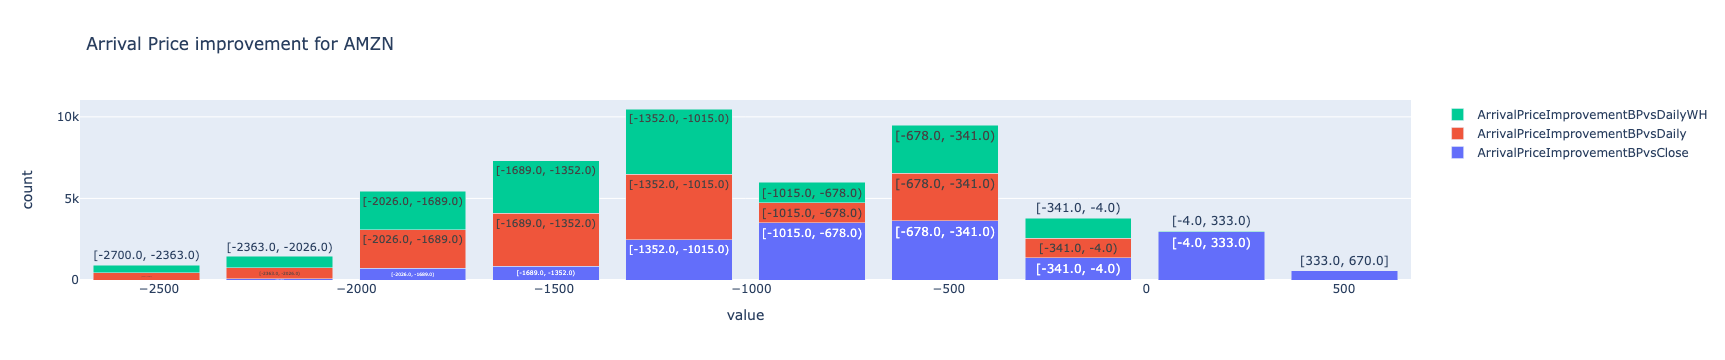

In [35]:
AMZN_price_imp.pandas_api()[['ArrivalPriceImprovementBPvsClose','ArrivalPriceImprovementBPvsDaily','ArrivalPriceImprovementBPvsDailyWH']].astype(float)\
.hist(title='Arrival Price improvement for AMZN')